### Visualization from lecture to get an overview

(198, 4096)
(198, 1)


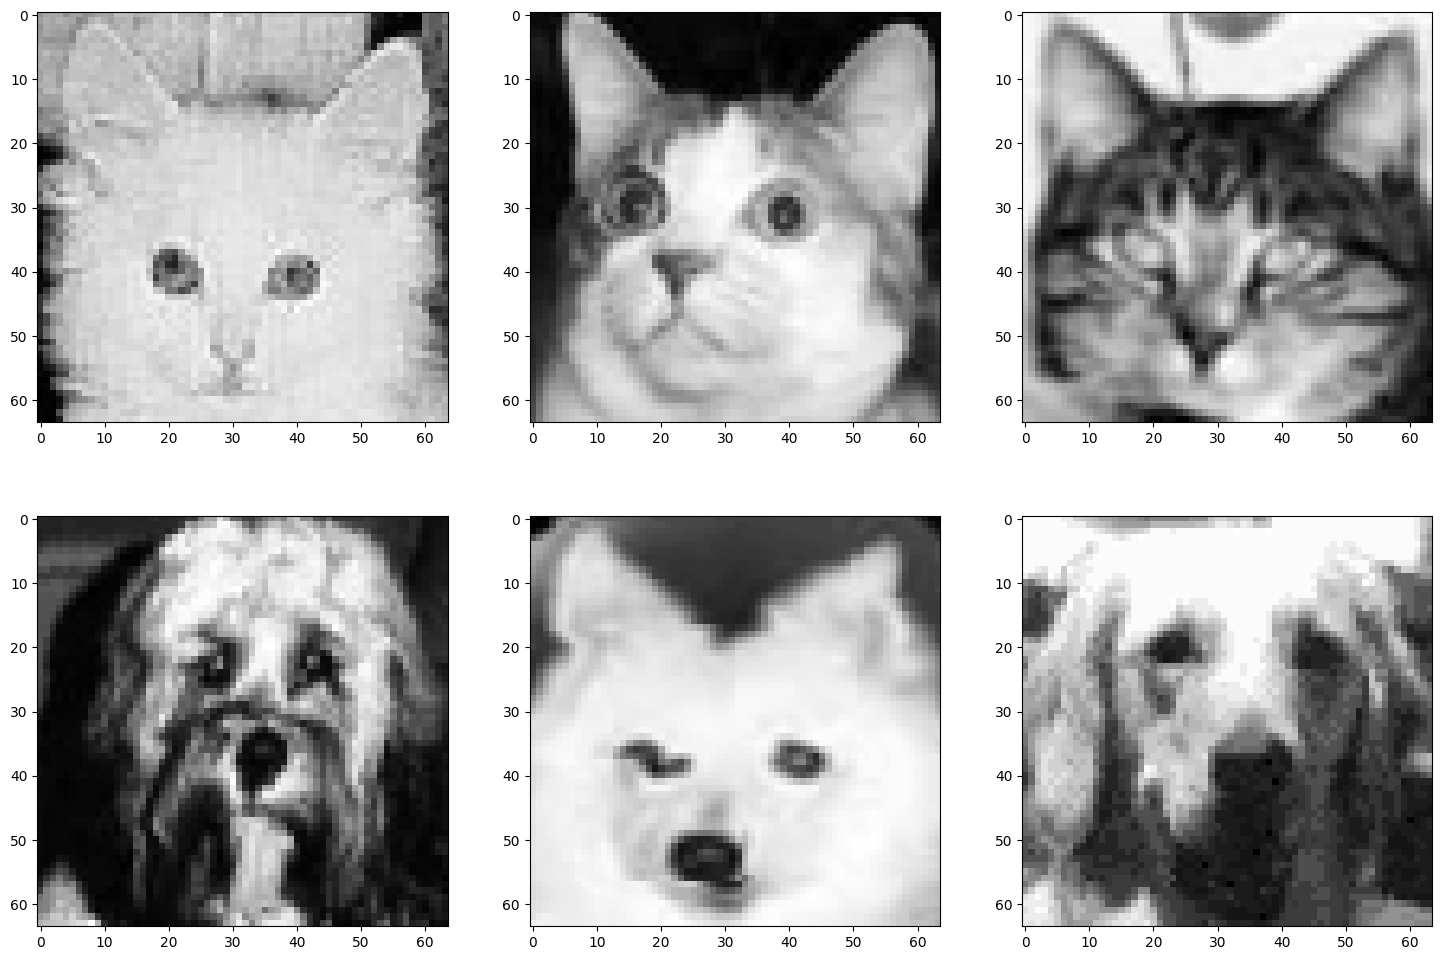

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import trange

CATSnDOGS = np.array(pd.read_csv("CATSnDOGS.csv"))
Labels = np.array(pd.read_csv("Labels.csv"))
print(np.shape(CATSnDOGS))
print(np.shape(Labels))

def rotateM(x):
    return np.transpose(np.apply_along_axis(np.flip, 0, x))

np.random.seed(1000012)
ssc = np.random.choice(np.where(Labels == 0)[0], 3, replace=False)
ssd = np.random.choice(np.where(Labels == 1)[0], 3, replace=False)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for i in range(3):
    axes[0][i].imshow(rotateM(np.reshape(CATSnDOGS[ssc[i], :], (64, 64))), cmap='gray')
    axes[0][i].set_xlabel("")
    axes[0][i].set_ylabel("")
    
for i in range(3):
    axes[1][i].imshow(rotateM(np.reshape(CATSnDOGS[ssd[i], :], (64, 64))), cmap='gray')
    axes[1][i].set_xlabel("")
    axes[1][i].set_ylabel("")

plt.show()

## Class separation

In [ ]:
def get_misclassified_indices(clf, features, labels, dataset):
    # Make predictions on the input data
    y_pred = clf.predict(features)
    
    # Find misclassified samples
    misclassified_idx = [i for i in range(len(labels)) if labels[i] != y_pred[i]]
    misclassified = features[misclassified_idx]
    
    # Find indices of misclassified samples in the original dataset
    indices = []
    for i in range(misclassified.shape[0]):
        image = misclassified[i,:]
        idx = np.where((dataset==image).all(axis=1))[0][0]
        indices.append(idx)
    
    return indices

In [4]:
# Classifiers
lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)


svm = make_pipeline(
    StandardScaler(),
    SVC()
)

rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(100,))
)


In [12]:
def prediction(classifier, name, iterations, data, removing_percentages=None):
    classifier_list = []
    for i in trange(iterations):
        # Split the data into training and testing sets
        train_features, test_features, train_labels, test_labels = train_test_split(data, Labels.ravel(), test_size=0.2)
        
        # Making new training data for data where images with missing pixels is removed
        if removing_percentages is not None:
            nr_of_images = len(train_labels)
            removing_indices = random.sample(range(nr_of_images), int(nr_of_images*removing_percentages))
            train_features = np.delete(train_features, removing_indices, axis=0)
            train_labels = np.delete(train_labels, removing_indices)


        # Train the classifiers using the pipeline
        classifier.fit(train_features, train_labels)

        # Make predictions on the testing data and calculate the accuracies
        classifier_pred = classifier.predict(test_features)
        classifier_acc = accuracy_score(test_labels, classifier_pred)

        classifier_list.append(classifier_acc)
    
    # Print the test accuracies
    print(name + " Accuracy:", np.mean(classifier_list)) 

In [8]:
classifiers = {'Logistic Regression': lr, 'Support Vector Machine': svm, 'Random Forest': rf, 'MLP': mlp}
iterations = 200
for name, classifier in classifiers.items():
    prediction(classifier, name, iterations, CATSnDOGS)
    

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.33it/s]


Logistic Regression Accuracy: 0.7565000000000001


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.69it/s]


Support Vector Machine Accuracy: 0.80025


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:24<00:00,  2.36it/s]


Random Forest Accuracy: 0.7445


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:17<00:00,  1.01it/s]

MLP Accuracy: 0.795625


### Reflection
Based on the results of the classifiers tested, it appears that the cats and dogs are relatively well separated, with classification accuracies ranging from 75% to 80%. This suggests that there is some overlap between the two categories, but the classifiers are still able to distinguish between them with a relatively high degree of accuracy. It may be useful to explore other metrics beyond accuracy, such as precision, recall, and F1-score, in order to get a more comprehensive picture of the performance of the classifiers.

In [54]:
def common(counts, threshold):
    most_common = []
    for key, count in counts.items():
        if count > threshold:
            most_common.append(key)
    most_common = sorted(most_common, key=lambda key: counts[key], reverse=True)
    return most_common

In [123]:
from collections import Counter

# Define lists to store the misclassified indices for each classifier
lr_indices_list = []
svm_indices_list = []
rf_indices_list = []
mlp_indices_list = []
all_indices = []

iterations = 1000


for i in trange(iterations):
    
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(CATSnDOGS, Labels.ravel(), test_size=0.2)

    # Train the classifiers using the pipeline
    lr.fit(train_features, train_labels)
    svm.fit(train_features, train_labels)
    rf.fit(train_features, train_labels)
    mlp.fit(train_features, train_labels)

    # Make predictions on the testing data
    lr_pred = lr.predict(test_features)
    svm_pred = svm.predict(test_features)
    rf_pred = rf.predict(test_features)
    mlp_pred = mlp.predict(test_features)

    # Get misclassified indices for each classifier and store them in separate lists
    lr_indices = get_misclassified_indices(lr, test_features, test_labels, CATSnDOGS)
    lr_indices_list = lr_indices_list + lr_indices
    
    svm_indices = get_misclassified_indices(svm, test_features, test_labels, CATSnDOGS)
    svm_indices_list = svm_indices_list + svm_indices
    
    rf_indices = get_misclassified_indices(rf, test_features, test_labels, CATSnDOGS)
    rf_indices_list = rf_indices_list + rf_indices
    
    mlp_indices = get_misclassified_indices(mlp, test_features, test_labels, CATSnDOGS)
    mlp_indices_list = mlp_indices_list + mlp_indices

    indices = lr_indices + svm_indices + rf_indices + mlp_indices
    all_indices = all_indices + indices


    
    
lr_counts = Counter(lr_indices_list)
svm_counts = Counter(svm_indices_list)
rf_counts = Counter(rf_indices_list)
mlp_counts = Counter(mlp_indices_list) 
    
## For separate classifiers
threshold_sep = iterations*0.2
lr_common = common(lr_counts, threshold_sep)
svm_common = common(svm_counts, threshold_sep)
rf_common = common(rf_counts, threshold_sep)
mlp_common = common(mlp_counts, threshold_sep)

# Find common elements between Logistic Regression and SVM
lr_svm_common = set(lr_common).intersection(set(svm_common))

# Find common elements between Logistic Regression, SVM, and Random Forest
lr_svm_rf_common = set(lr_common).intersection(set(svm_common)).intersection(set(rf_common))

# Find common elements between all arrays
all_common = set(lr_common).intersection(set(svm_common)).intersection(set(rf_common)).intersection(set(mlp_common))

print('Common elements between Logistic Regression and SVM:', lr_svm_common)
print('Common elements between Logistic Regression, SVM, and Random Forest:', lr_svm_rf_common)
print('Common elements between all arrays:', all_common)


## For all classifiers
# If a image was misclassified more than 20% of the time
counts = Counter(all_indices)
nr_clfs = 4
threshold = nr_clfs * iterations * 0.2
most_common = common(counts, threshold)

# Print most common misclassified images
print(f'Most common misclassified images: {most_common}')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [32:43<00:00,  1.96s/it]

Common elements between Logistic Regression and SVM: {37, 8, 12, 114, 117, 151, 93}
Common elements between Logistic Regression, SVM, and Random Forest: {37, 8, 12, 114, 117, 151, 93}
Common elements between all arrays: {37, 8, 114, 117, 151, 93}
Most common misclassified images: [37, 114, 8, 151, 117, 93]


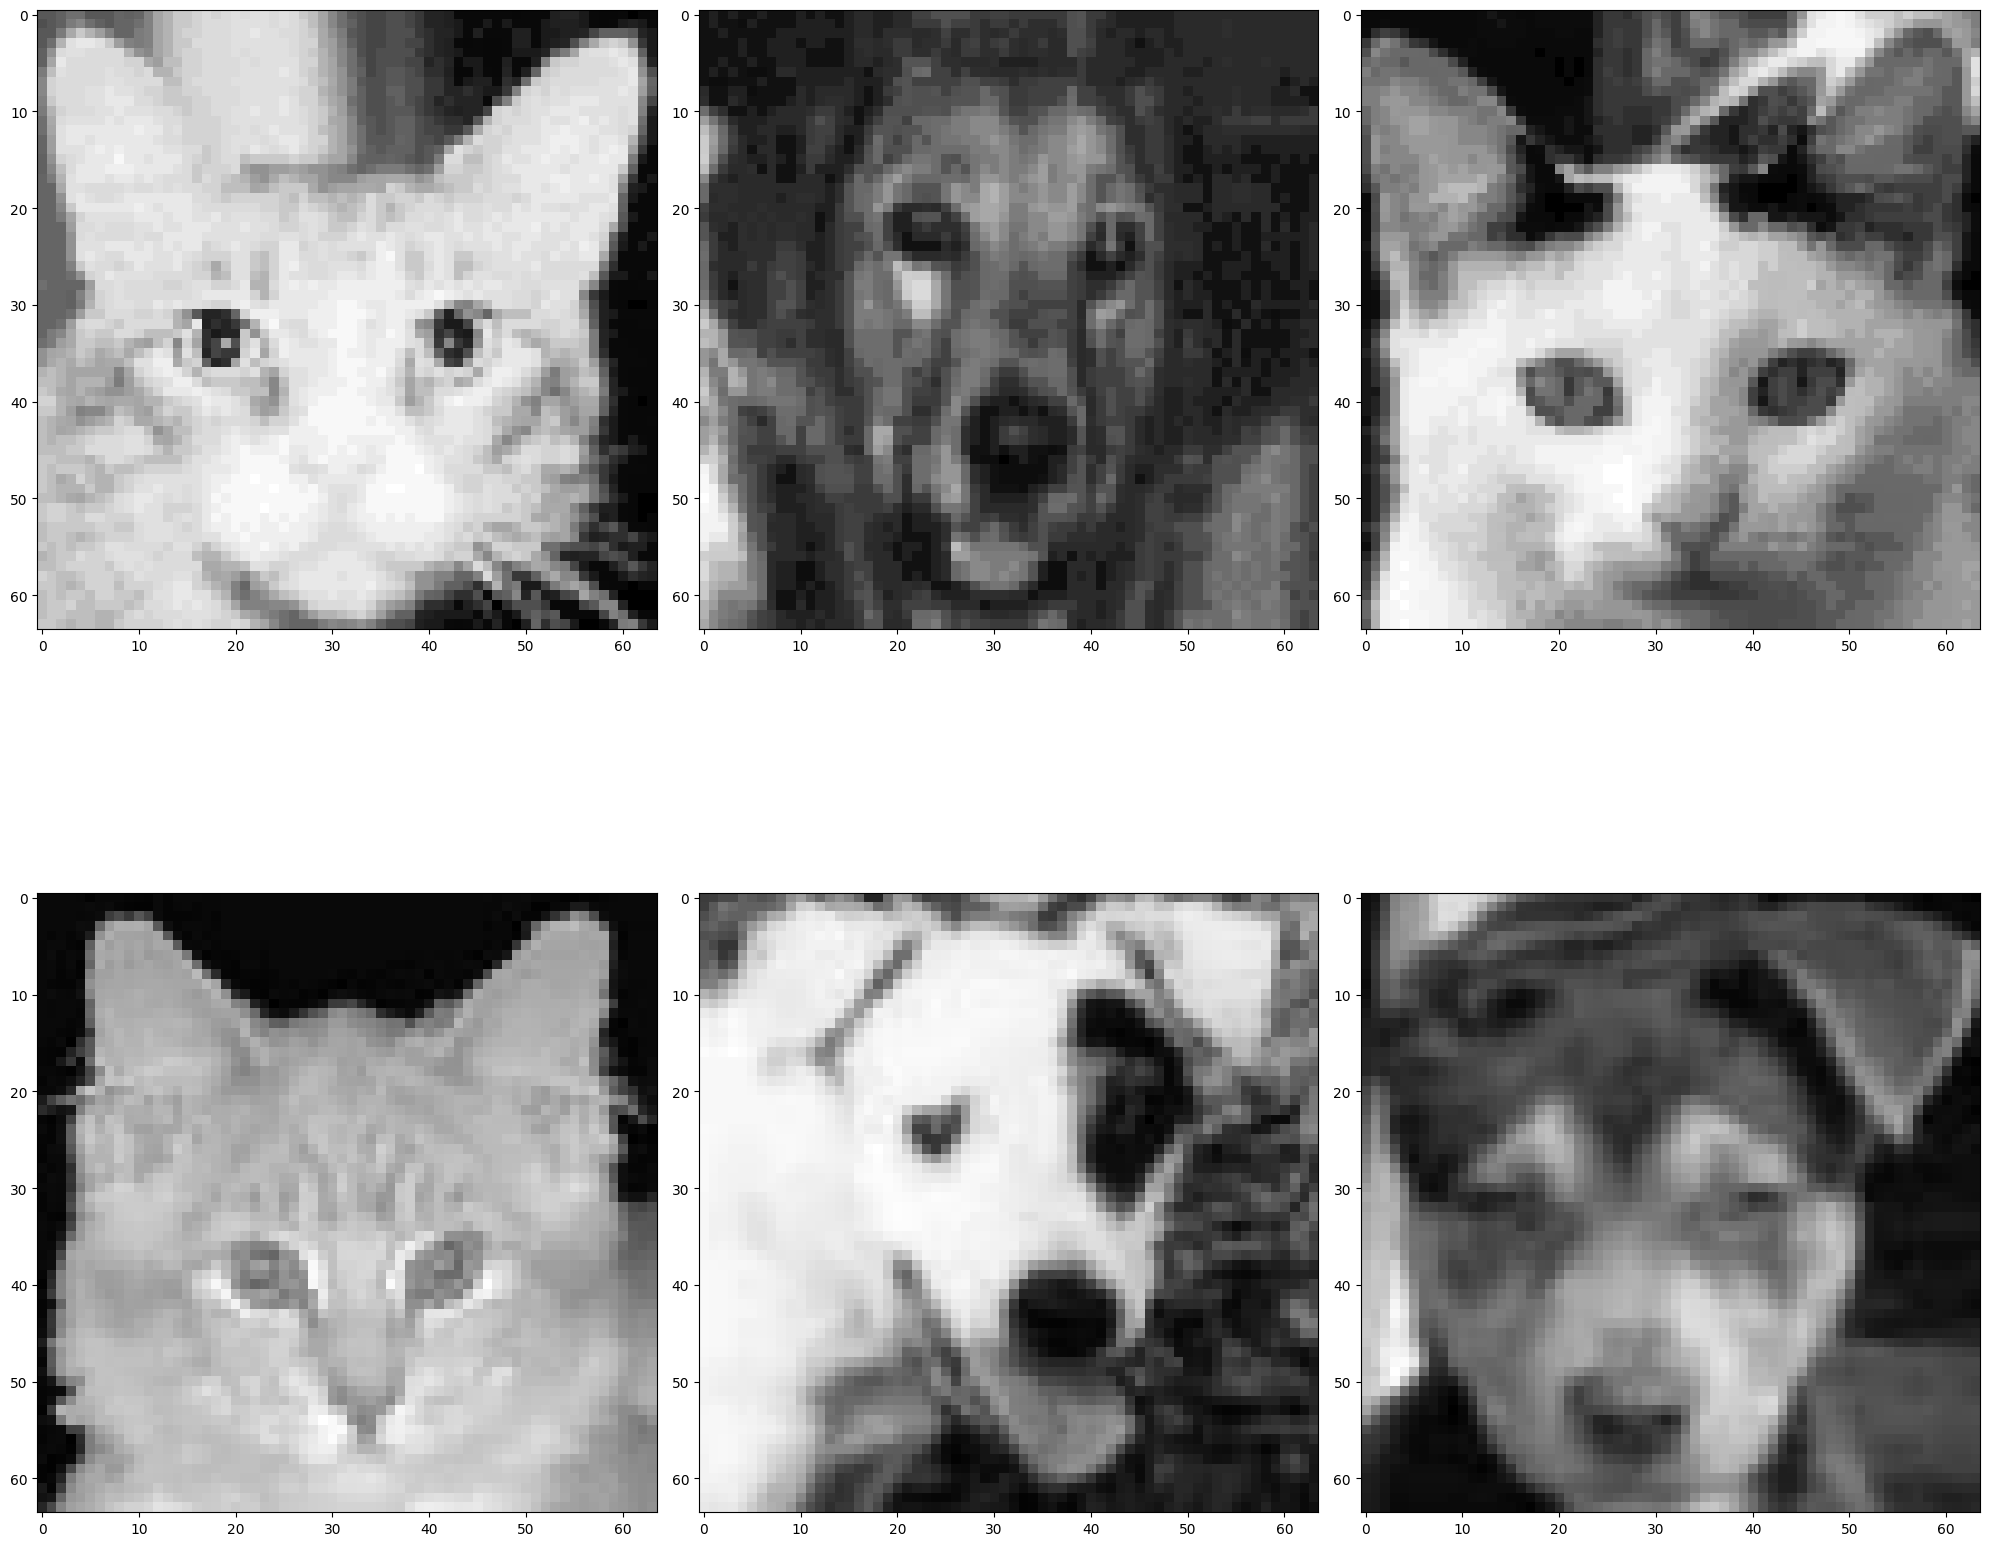

In [125]:
# Show the 6 most misclassified images
rows = 2
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
id = 0
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(rotateM(np.reshape(CATSnDOGS[most_common[id], :], (64, 64))), cmap='gray')
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
        id += 1
plt.tight_layout()

### Reflection
Several images of cats and dogs are consistently misclassified by all classifiers, particularly those featuring pets with sharply pointed ears. This is likely due to the similarity in shape between the ears of cats and dogs, making it difficult for the models to differentiate between the two. It could also be due to the positioning of the ears. Additionally, the presence of eyes with little difference in color between pupil and iris may also pose a challenge for accurate classification.

## Feature selection
Identify the most important pixels for classification - are these easy to identify or is there uncertainty in the selection of important features? Compare at least 2 methods for selecting/identifying features. Note, does not need to be the same methods as in 1a. Can you think of a way to improve on the stability of selection/identification?

Can you explain why these pixels are selected/are deemed important?

Do the identified predictive features differ between the classification methods?

In [79]:
def filter_counter_dict(counter_dict, threshold):
    filtered_dict = {}
    for key, value in counter_dict.items():
        if value > threshold:
            filtered_dict[key] = value
    return filtered_dict

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_counts(feature_counts, title):
    # Create bar plot
    sns.barplot(x=list(feature_counts.keys()), y=list(feature_counts.values()), color='blue')
    
    # Set x-axis label
    plt.xlabel('Feature index')

    # Set y-axis label
    plt.ylabel('Count')

    # Rotate x-axis ticks for better readability
    plt.xticks(rotation=90)
    
    plt.title(title)
    # Show the plot
    plt.show()




In [156]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from tqdm import trange

reg_list = []
tree_list = []
combined_list = []
nr_iterations = 300

for i in trange(nr_iterations):
    # Split data
    train_features, test_features, train_labels, test_labels = train_test_split(CATSnDOGS, Labels.ravel(), test_size=0.2)

    # Regularization method
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000).fit(train_features, train_labels)
    model = SelectFromModel(lsvc, prefit=True)
    important_features = model.transform(train_features)

    # Get the indices of the selected features
    selected_indices = model.get_support(indices=True).tolist()
    reg_list += selected_indices
    
    # Tree-based feature selection
    n_jobs = -1
    forest = RandomForestClassifier(n_estimators=750, n_jobs=n_jobs)
    forest.fit(train_features, train_labels)
    importances = forest.feature_importances_
    
    # Get the indices of the most important features
    important_indices = importances.argsort()[::-1]
    important_indices = important_indices[:len(selected_indices)].tolist() #Only take as many as the indices of regularized
    tree_list += important_indices
    
    
combined_list = tree_list + reg_list

reg_counts = Counter(reg_list)
tree_counts = Counter(tree_list)
combined_counts = Counter(combined_list)
    


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [16:59<00:00,  3.40s/it]


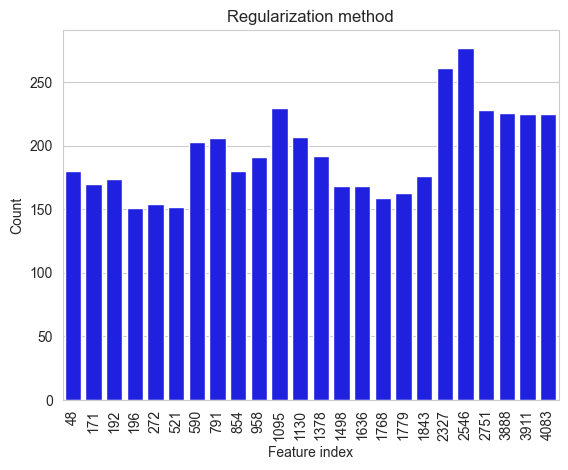

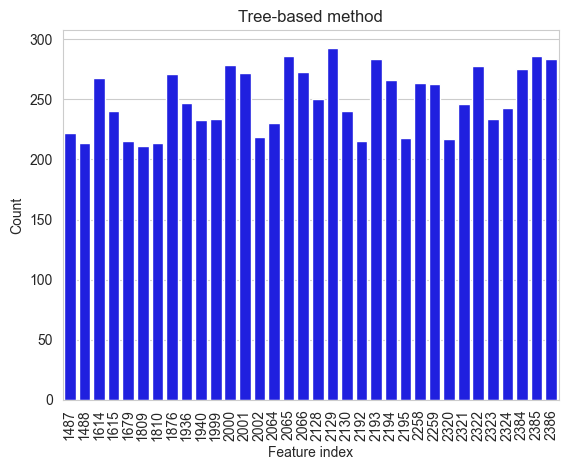

In [160]:
threshold = nr_iterations * 0.5
filtered_dict_reg = filter_counter_dict(reg_counts, threshold)

threshold = nr_iterations * 0.7
filtered_dict_tree = filter_counter_dict(tree_counts, threshold)

plot_feature_counts(filtered_dict_reg, 'Regularization method')
plot_feature_counts(filtered_dict_tree, 'Tree-based method')

In [163]:
# Only consider features that have been selected 20% of the time
threshold = nr_iterations * 0.2
most_selected_features_reg = common(reg_counts, threshold)
most_selected_features_tree = common(tree_counts, threshold)
common_features = set(most_selected_features_reg).intersection(set(most_selected_features_tree))
print(f'Most selected features by reg: {most_selected_features_reg}')
print(f'Most selected features by tree: {most_selected_features_tree}')
print(f'Common features picked by both classifiers: {common_features}')

Most selected features by reg: [2546, 2327, 1095, 2751, 3888, 3911, 4083, 1130, 791, 590, 1378, 958, 48, 854, 1843, 192, 171, 1498, 1636, 1779, 1768, 272, 521, 196, 1705, 344, 3017, 971, 3847, 3, 3912, 3369, 1101, 2038, 3194, 895, 2531, 2386, 3586, 2937, 1951, 3372, 1704, 1778, 3970, 1497, 1486, 1634, 3801, 3434, 2111, 25, 1642, 2852, 4086, 3320, 3169, 3366, 4044, 55, 2756, 1654, 2030, 1092, 49, 3257, 3433, 1952, 523, 3633, 1161, 1319, 2495, 1117, 3457, 2037, 2217, 1572, 2623, 3351, 407, 1061, 2545, 275, 1936, 3336, 1943, 1641, 3634, 134, 3901, 2253, 589, 586, 733, 3337, 3989, 4088, 1904, 1005, 3335, 669, 2381, 1970, 2166, 1950, 3302, 4082, 2273, 2274, 3041, 524, 2189, 1314, 1907, 1971, 1118, 52, 4045, 3968, 3080, 3653, 1418, 3338, 1124, 1780, 3573, 3846, 2731]
Most selected features by tree: [2129, 2385, 2065, 2386, 2193, 2000, 2322, 2384, 2066, 2001, 1876, 1614, 2194, 2258, 2259, 2128, 1936, 2321, 2324, 2130, 1615, 1999, 2323, 1940, 2064, 1487, 2002, 2195, 2320, 1679, 2192, 1488, 181

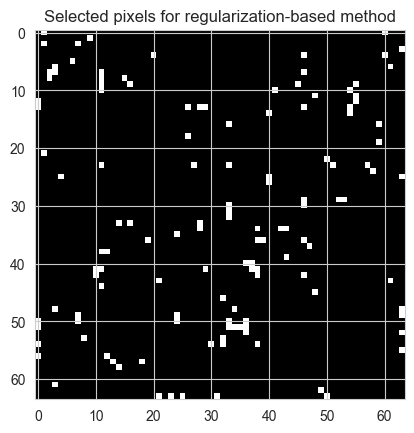

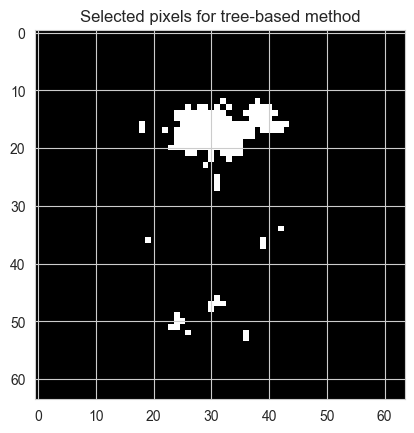

In [165]:
image = np.zeros((1, 4096))
image[0, most_selected_features_reg] = 1
plt.imshow(rotateM(np.reshape(image, (64, 64))), cmap='gray')
plt.title('Selected pixels for regularization-based method')
plt.show()

image = np.zeros((1, 4096))
image[0, most_selected_features_tree] = 1
plt.imshow(rotateM(np.reshape(image, (64, 64))), cmap='gray')
plt.title('Selected pixels for tree-based method')
plt.show()

### Reflection
Based on the results obtained from the feature selection techniques used in the classification of dogs and cats images, it appears that the regularization-based method tends to prioritize the pixels located at the outer edges of the silhouettes of the animals. On the other hand, the tree-based method assigns more importance to the pixels located on the forehead area between the ears, with some additional pixels in the mouth/chin region.

Determining why certain pixels are more important than others in feature selection can be a challenging task. Moreover, selecting specific pixels with confidence is also difficult. In cases where feature selection is performed on a single or a few instances, the selected features are likely to change, leading to uncertainty in the selected features. To mitigate this, it is recommended to resample the train-test split over several iterations and perform feature selection multiple times to reduce uncertainty. Nevertheless, some pixels are consistently selected by both classifiers, which may suggest their importance. In general, the feature selection methods tend to select different sets of features with less overlap than variation.

#### Improve stability
There are several ways to potentially improve the stability of feature selection. Here are a few:

- Using bootstrap resampling feature selection
- Increase the number of bootstrap samples: By increasing the number of bootstrap samples, we can get a better estimate of the stability of each feature. However, this comes at the cost of increased computational time.

- Perform feature selection in multiple stages: By performing feature selection in multiple stages, we can potentially reduce the impact of noise or instability in the selection process. For example, we could first use a more robust method to select a small set of features, and then use a more sensitive method to further refine the selection.


## Difference between the feature selection methods
The observation that regularization-based method prioritizes the pixels at the outer edges of the silhouettes of the animals while the tree-based method assigns more importance to the pixels located on the forehead area between the ears and mouth/chin region, could be due to the different ways the methods assign importance to the features. Regularization-based methods use penalties to encourage sparse feature selection, and may favor features that have a high correlation with the outcome but are not redundant with other selected features. On the other hand, tree-based methods use decision trees to recursively partition the feature space, and may assign importance to features that lead to informative splits in the tree. However, it is difficult to determine the exact reason why certain pixels are considered more important than others, and it is also challenging to be confident in the selection of specific pixels. Using stability selection, as discussed earlier, could improve the confidence in the selected features. Overall, the observation that the two methods tend to select different sets of features with less overlap than variation suggests that combining the two methods may lead to a more robust feature selection process.

### Feature Selection with Bootstrap Resampling
Bootstrap resampling feature selection is a good way to increase certainty because it involves repeatedly resampling the training set and performing feature selection on each resampled dataset. By doing this, we are able to obtain multiple estimates of the selected features, which can be used to compute the stability of the feature selection. Features that are consistently selected across multiple resampled datasets are more likely to be important than features that are only selected in a few resampled datasets.

By using this approach, we can increase our confidence in the selected features and reduce the uncertainty associated with the feature selection process. Additionally, we can estimate the variability in the feature selection results and obtain a more accurate picture of the important features in the dataset. This can help to avoid overfitting and improve the generalizability of the model. Overall, bootstrap resampling feature selection is a robust and reliable method for selecting important features in a dataset.

Bootstrap resampling with replacement also introduces some level of noise into the feature selection process, which can help to reduce overfitting and improve the generalization of the feature selection model. The following implementation with ShuffleSplit uses replacement

### Impurity heat map

Elapsed time to compute the importances: 0.258 seconds


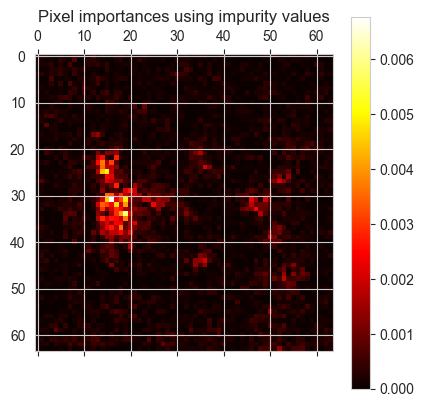

In [167]:
import time
import matplotlib.pyplot as plt

img_shape = (64, 64)
importances = forest.feature_importances_

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
imp_reshaped = importances.reshape(img_shape)
plt.matshow(imp_reshaped, cmap=plt.cm.hot)
plt.title("Pixel importances using impurity values")
plt.colorbar()
plt.show()

## Task 2
### Setting level of missingness

In [13]:
#Procent of defected pictures
level1_procent_pictures = 0.2
level2_procent_pictures = 0.5

#Procent of defected pixels in each picture for random
level1_procent_pixels = 0.2
level2_procent_pixels = 0.6

#Procent of defected pixels in each picture for "bias"
level1_procent_overbias = 0.9
level1_procent_underbias = 0

level2_procent_overbias = 0.5
level2_procent_underbias = 0.06

### Generating "missing"-images random
#### For level 1

In [14]:
import random
#Create a copy of the dataset to defect
dataset_level1 = CATSnDOGS.copy()
labels_level1 = Labels.copy()



# Findes the index of the pictures to be damaged
nr_of_images = len(Labels)
defected_images_level1 = random.sample(range(nr_of_images), int(nr_of_images*level1_procent_pictures))  

# Damage the pictures
for index in defected_images_level1:
    picture = dataset_level1[index, :]
    
    delete_pixel_index = random.sample(range(len(picture)), int(len(picture)*level1_procent_pixels))

    for i in delete_pixel_index:
        picture[i] = 0
    
    dataset_level1[index, :] = picture

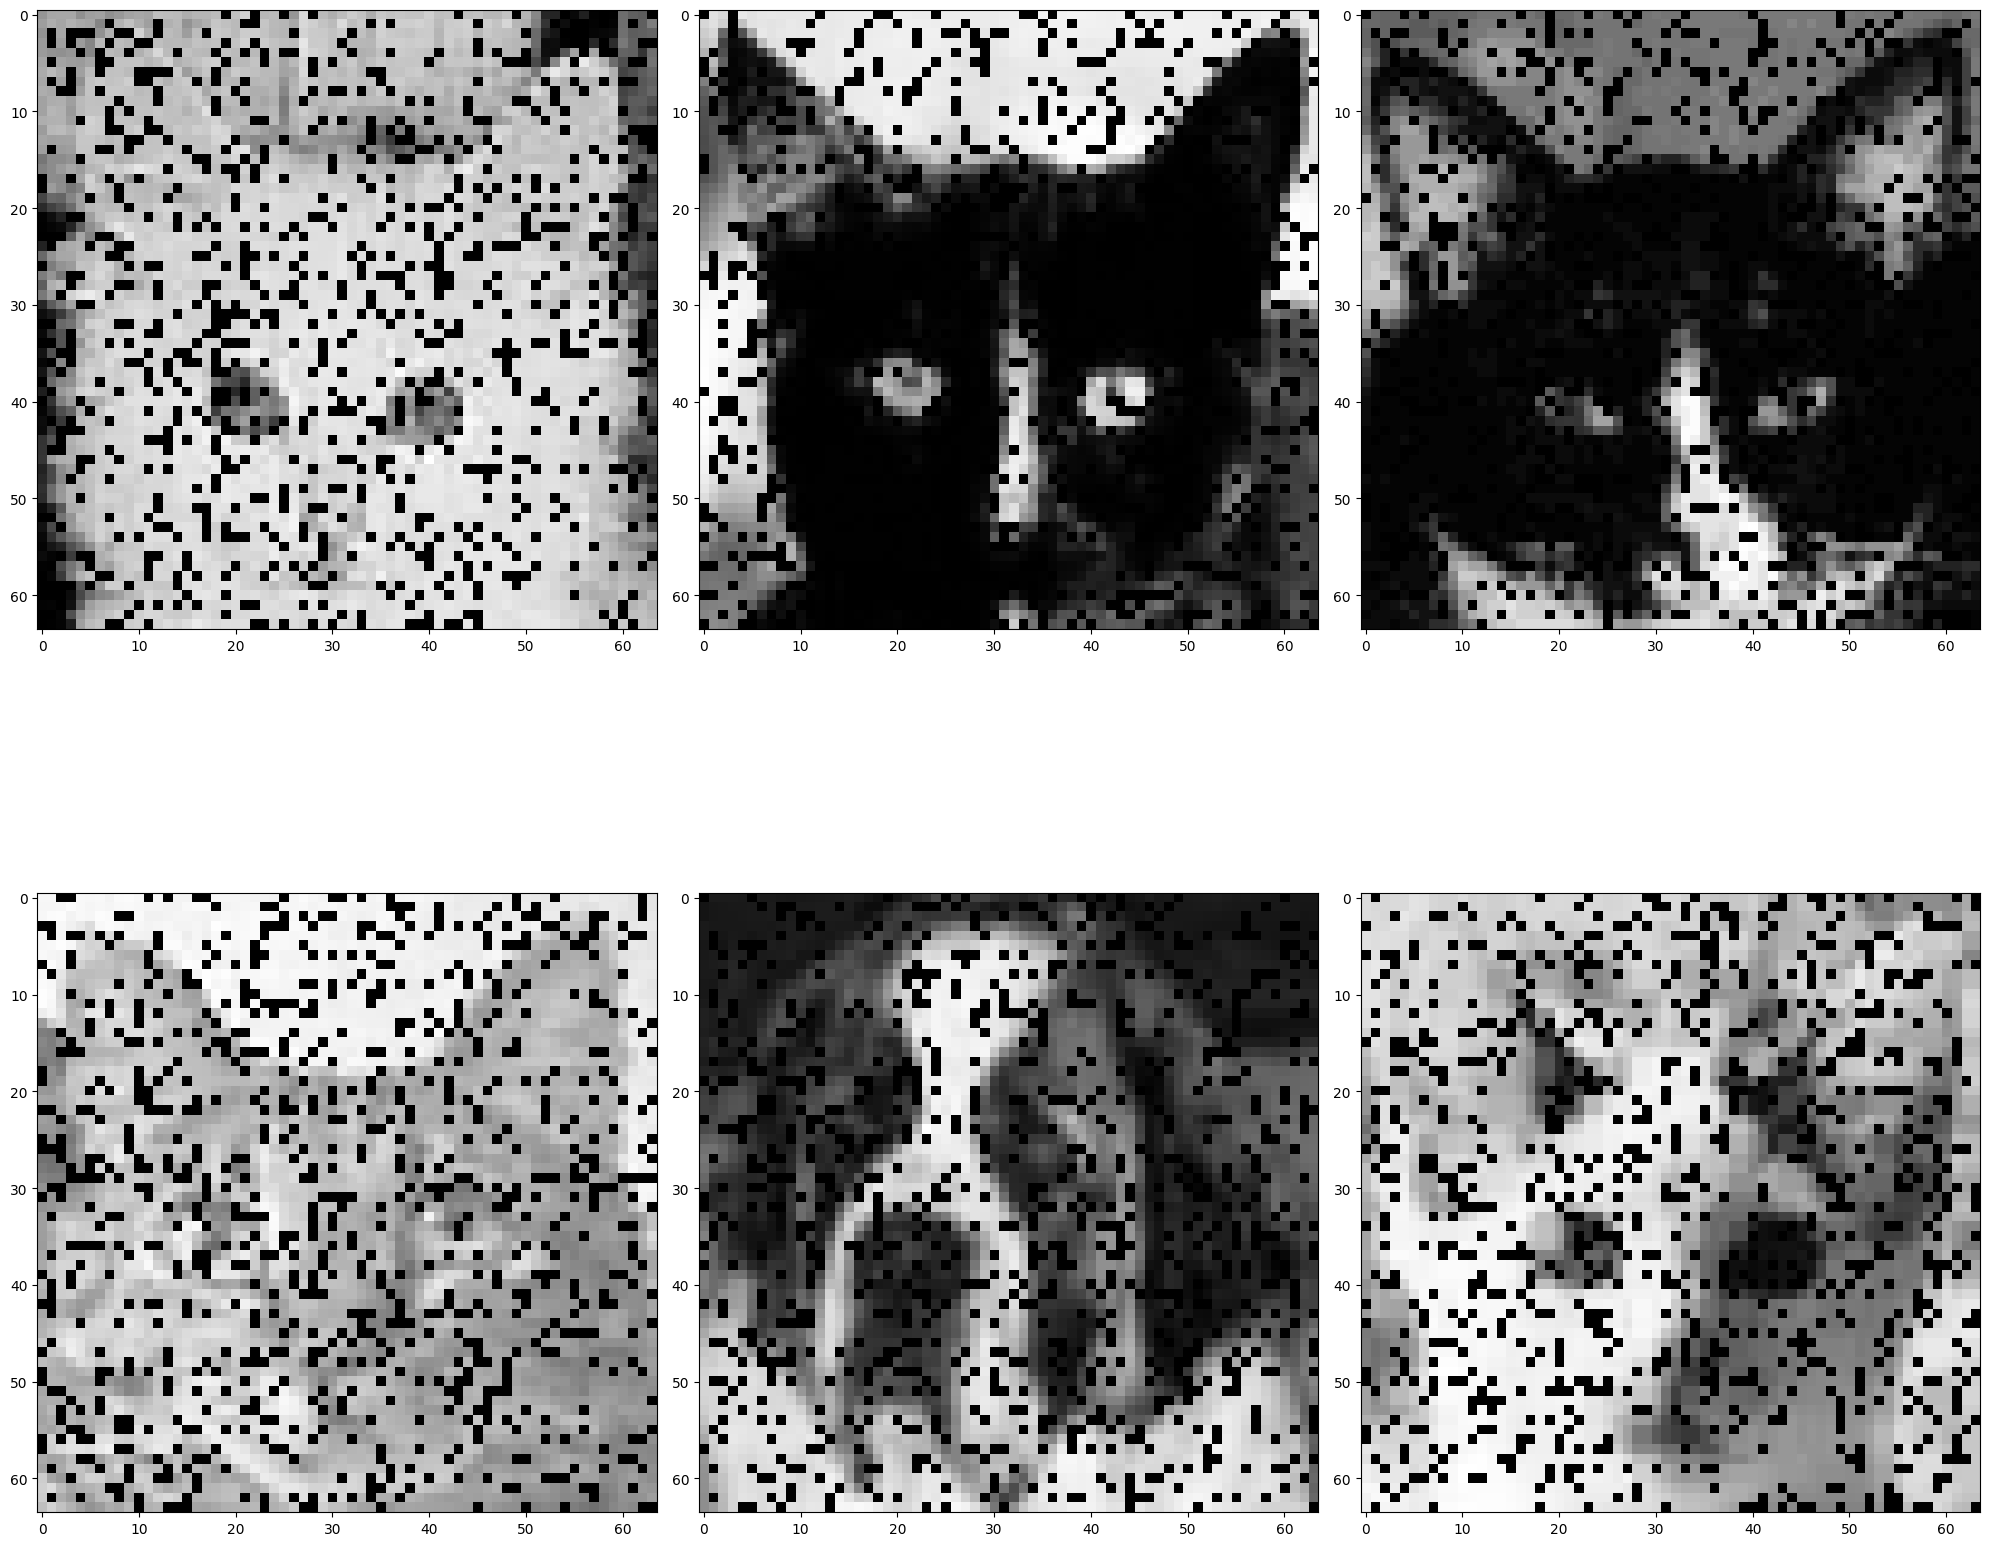

In [15]:
#To visualize the defects
rows = 2
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
id = 0
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(rotateM(np.reshape(dataset_level1[defected_images_level1[id], :], (64, 64))), cmap='gray')
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
        id += 1
plt.tight_layout()

***Removing observations/images that has any missing pixels***

In [17]:


# Classifiers
lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)


svm = make_pipeline(
    StandardScaler(),
    SVC()
)

rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

mlp = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(100,))
)


iterations = 200
classifiers = {'Logistic Regression': lr, 'Support Vector Machine': svm, 'Random Forest': rf, 'MLP': mlp}
for name, classifier in classifiers.items():
    prediction(classifier, name, iterations, CATSnDOGS, level1_procent_pictures)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.41it/s]


Logistic Regression Accuracy: 0.7615000000000001


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.37it/s]


Support Vector Machine Accuracy: 0.7827500000000001


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:10<00:00,  2.85it/s]


Random Forest Accuracy: 0.738125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:53<00:00,  1.15it/s]

MLP Accuracy: 0.7875


#### For level 2

In [18]:
# Creates a copy of the dataset
dataset_level2 = CATSnDOGS.copy()
labels_level2 = Labels.copy()

# Findes the index of the pictures to be damaged
nr_of_images = len(Labels)
defected_images_level2 = random.sample(range(nr_of_images), int(nr_of_images*level2_procent_pictures))

#Damages the shit
for index in defected_images_level2:
    picture = dataset_level2[index, :]
    
    delete_index = random.sample(range(len(picture)), int(len(picture)*level1_procent_pixels))

    for i in delete_index:
        picture[i] = 0
    
    dataset_level2[index, :] = picture

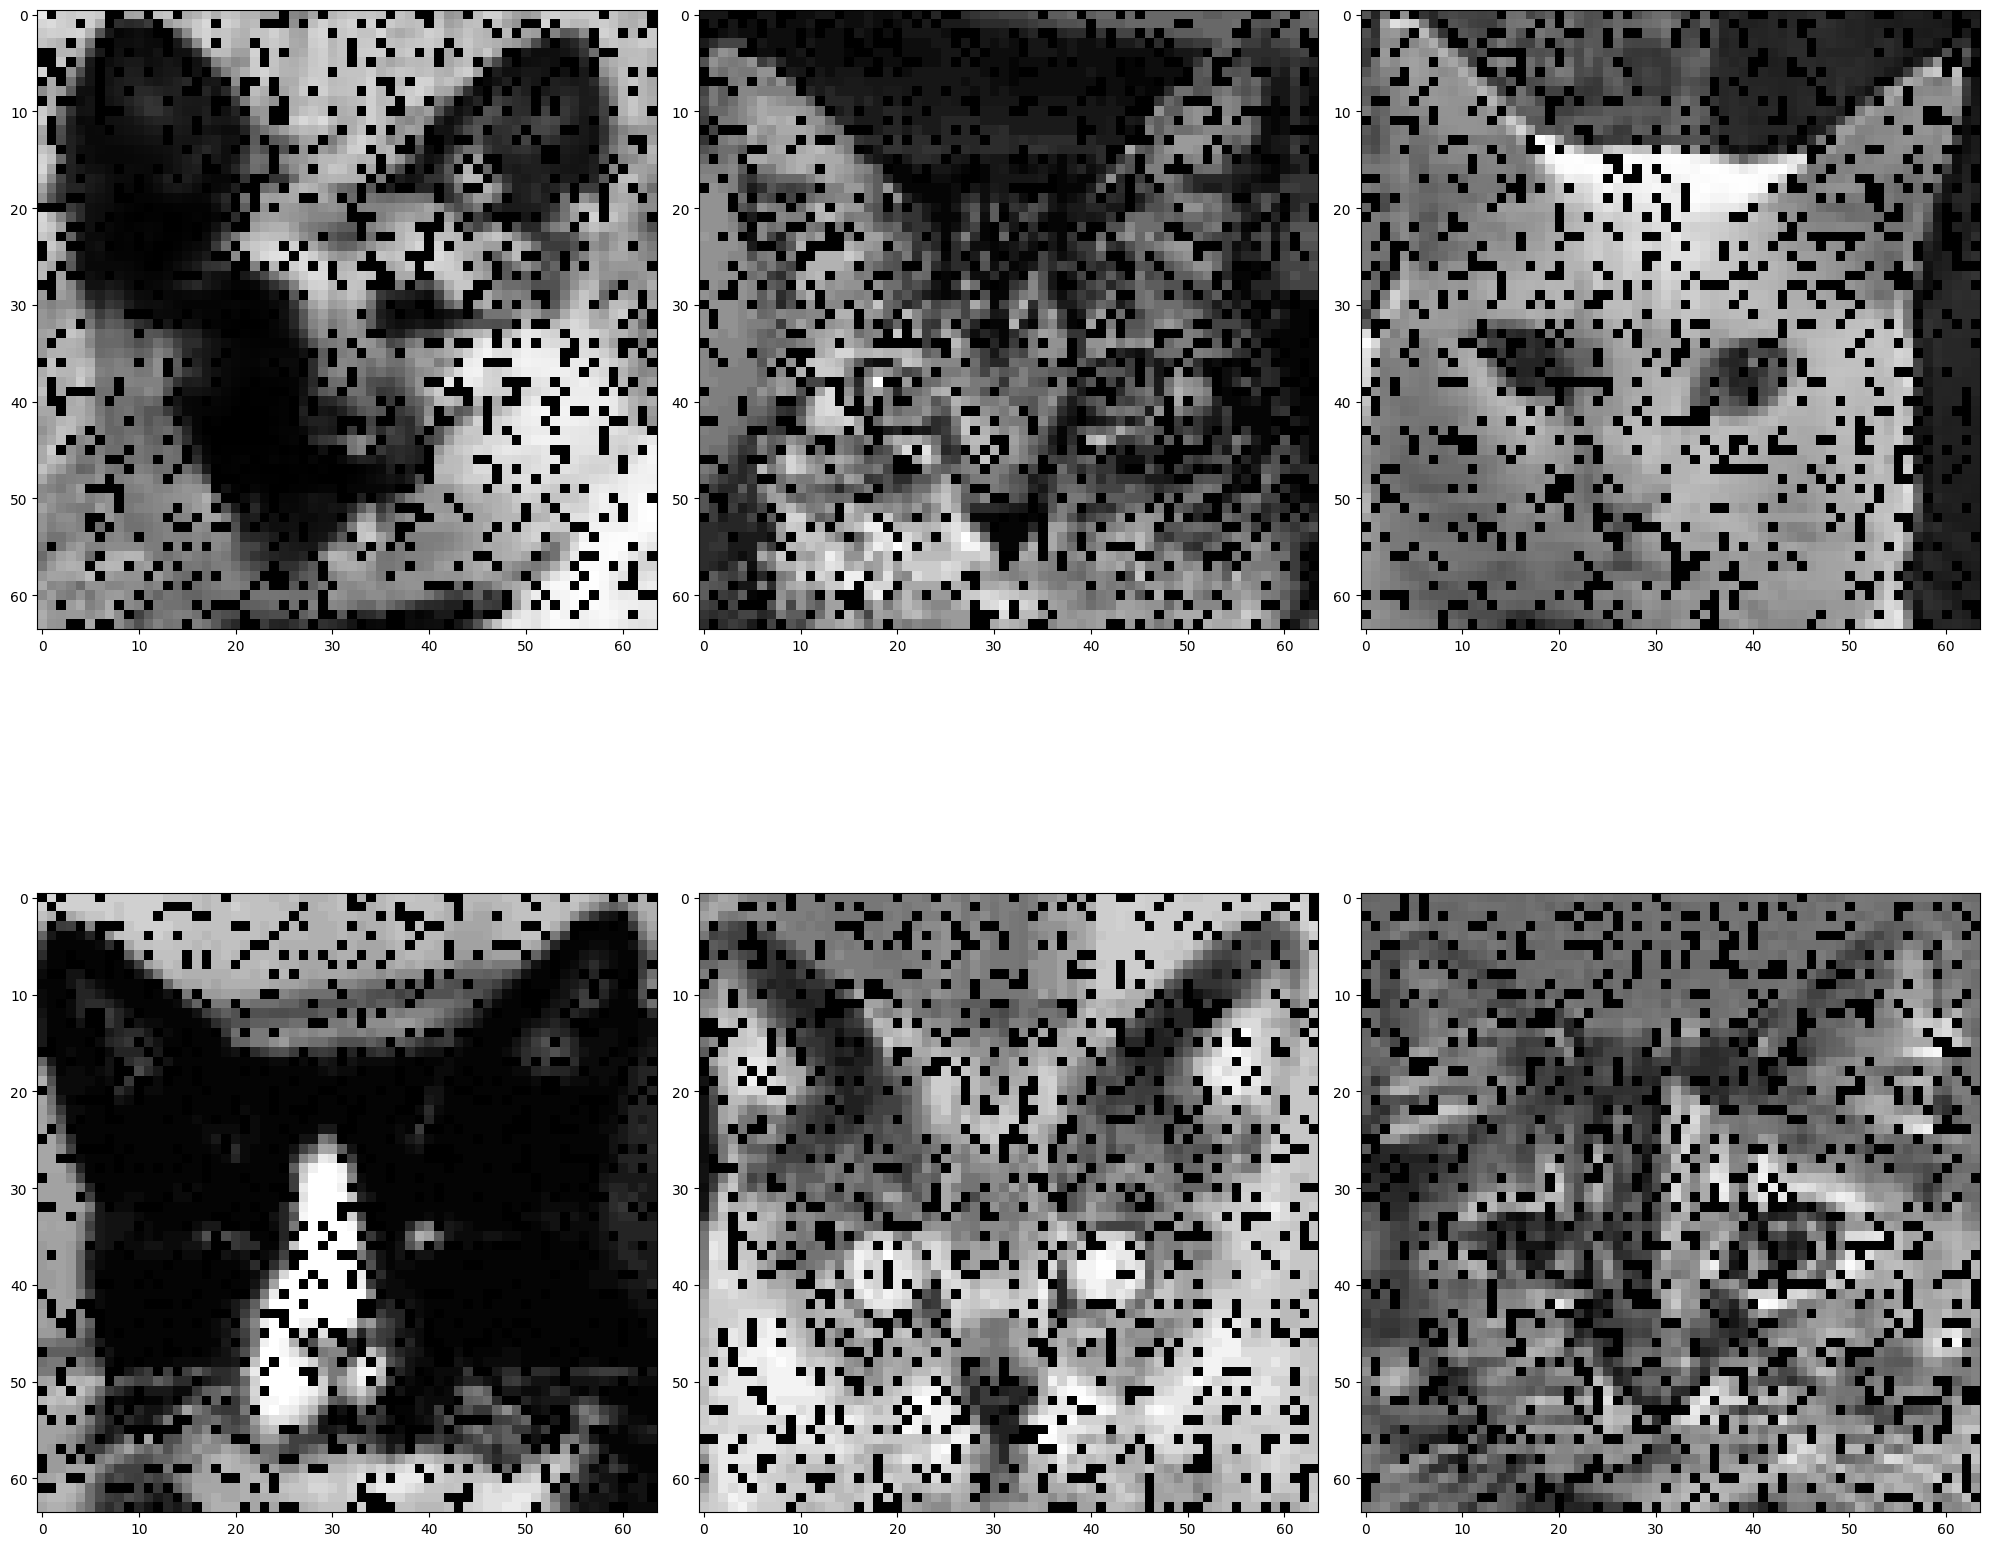

In [19]:
#To visualize the defects
rows = 2
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
id = 0
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(rotateM(np.reshape(dataset_level2[defected_images_level2[id], :], (64, 64))), cmap='gray')
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
        id += 1
plt.tight_layout()

### Generating "missing"-images with bias
#### Set bias

In [20]:
# Bilder med värde över detta kommer att muteras mer
bias = 0.9

### Level 1

In [21]:
#Create a copy of the dataset to defect

dataset_level1 = CATSnDOGS.copy()
labels_level1 = Labels.copy()

# Findes the index of the pictures to be damaged
nr_of_images = len(Labels)
defected_images_level1 = random.sample(range(nr_of_images), int(nr_of_images*level1_procent_pictures))

#Damages the shit
for index in defected_images_level1:
    picture = dataset_level1[index, :]
    
    for i in range(len(picture)):
        r = np.random.rand()
        if picture[i] >= bias*max(picture):
            if r < level1_procent_overbias:
                picture[i] = 0
            
        else:
            if r < level1_procent_underbias:
                picture[i] = 0

    dataset_level1[index, :] = picture

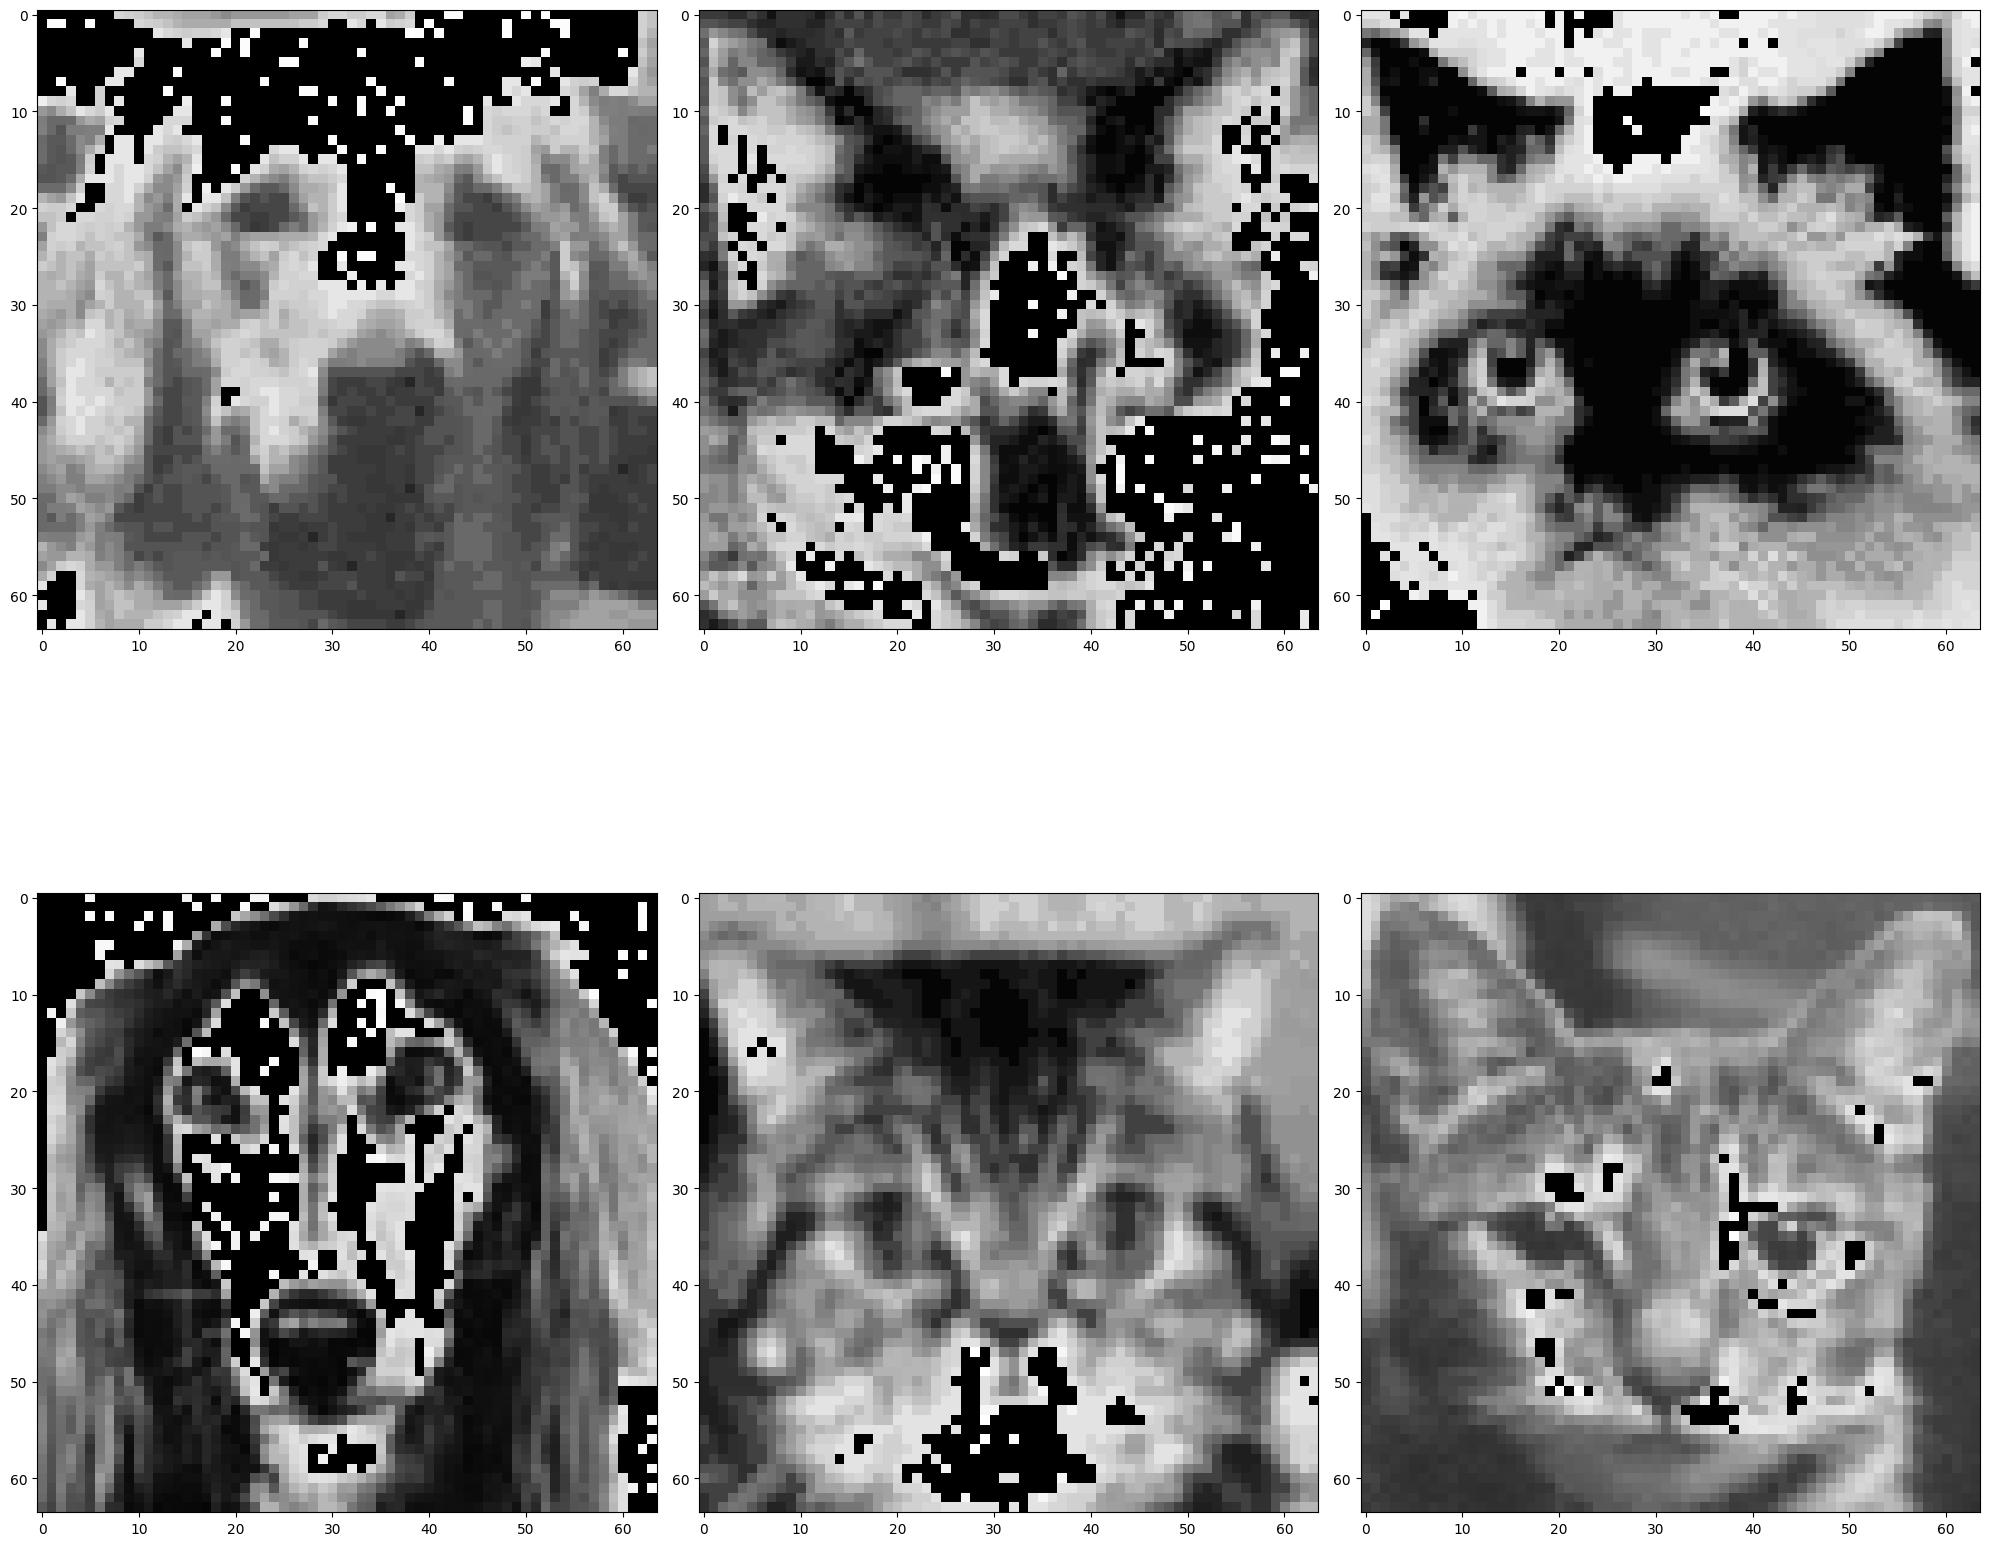

In [22]:
#To visualize the defects
rows = 2
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
id = 0
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(rotateM(np.reshape(dataset_level1[defected_images_level1[id], :], (64, 64))), cmap='gray')
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
        id += 1
plt.tight_layout()

### Level 2

In [23]:
# Creates a copy of the dataset
dataset_level2 = CATSnDOGS.copy()
labels_level2 = Labels.copy()

# Findes the index of the pictures to be damaged
nr_of_images = len(Labels)
defected_images_level2 = random.sample(range(nr_of_images), int(nr_of_images*level2_procent_pictures))


#Damages the shit
for index in defected_images_level2:
    picture = dataset_level2[index, :]
    
    for i in range(len(picture)):
        r = np.random.rand()
        if picture[i] >= bias*max(picture):
            if r < level2_procent_overbias:
                picture[i] = 0
            
        else:
            if r < level2_procent_underbias:
                picture[i] = 0

    dataset_level2[index, :] = picture

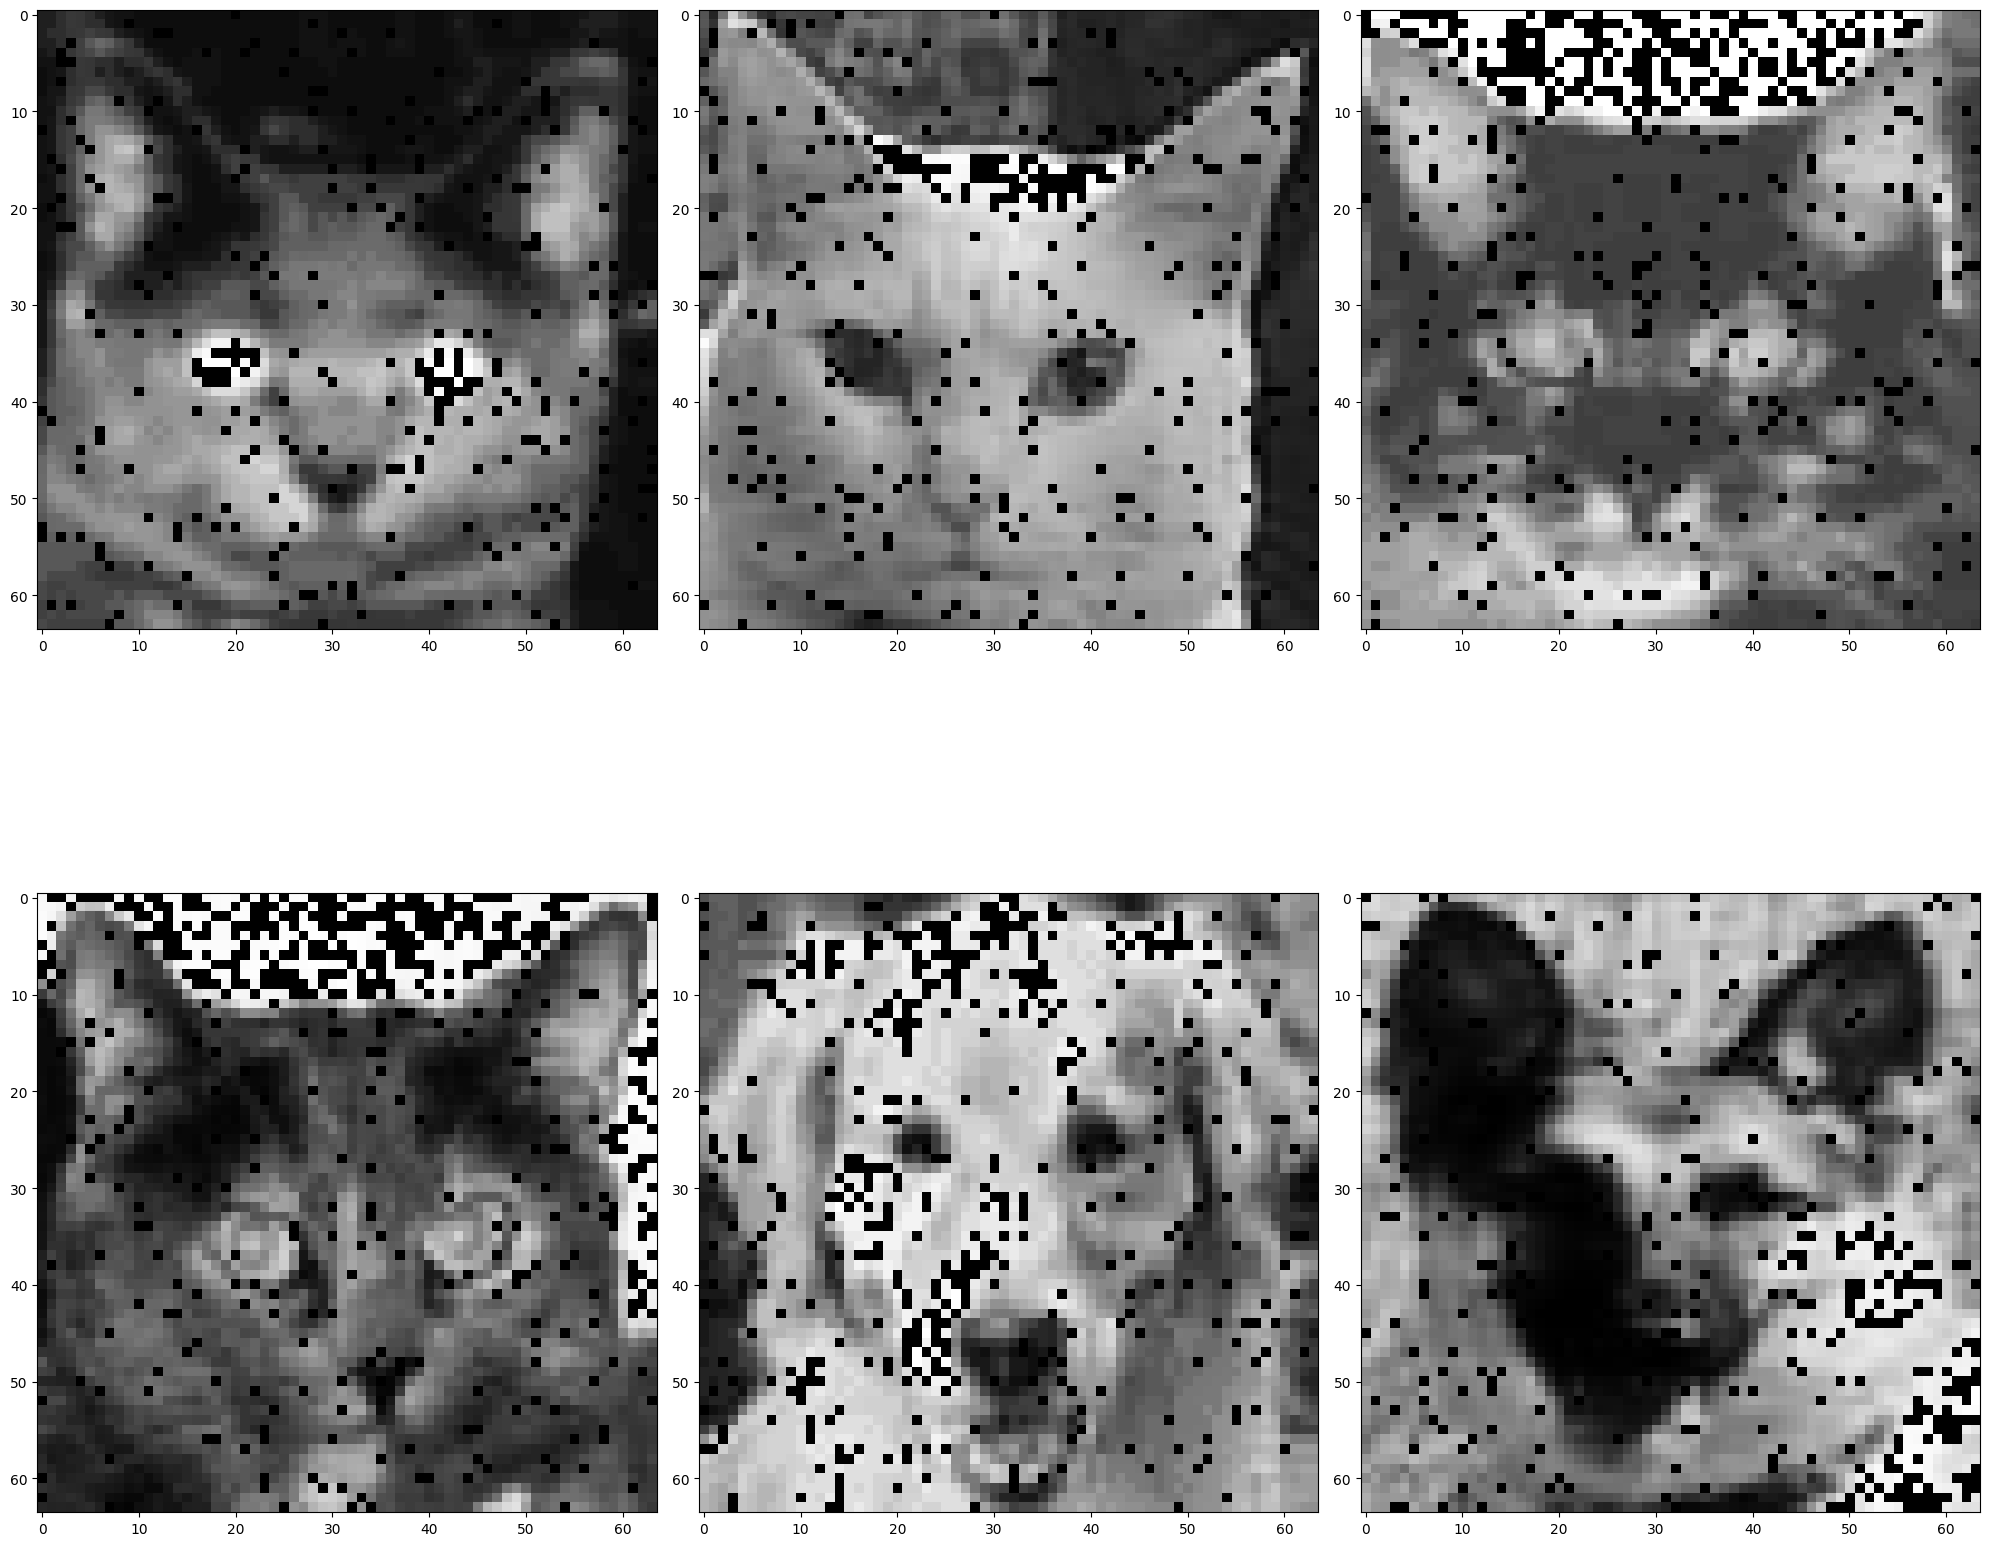

In [24]:

#To visualize the defects
rows = 2
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
id = 0
for i in range(rows):
    for j in range(cols):
        axes[i][j].imshow(rotateM(np.reshape(dataset_level2[defected_images_level2[id], :], (64, 64))), cmap='gray')
        axes[i][j].set_xlabel("")
        axes[i][j].set_ylabel("")
        id += 1
plt.tight_layout()